# Import Libraries

In [1]:
# !pip install -q -U tensorflow-gpu==2.10.0
# !pip install -q -U tensorflow_hub
# !pip install -q scikeras
# !pip install -q catboost
# !pip install -q opencv-python
# !pip install -q shap
# !pip install -q -U segment_anything
# !pip install -q -U torch
# !pip install -q -U typing_extensions
# !pip install -q -U Cython
# !pip install -q -U sympy
# !pip install -q -U torchvision

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import tensorflow as tf
import torch

print(tf.test.is_built_with_cuda())

gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs: ", len(gpus))

# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
#         )
#         if len(gpus) > 1:
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpus[1],
#                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
#             )
#     except RuntimeError as e:
#         print(e)

In [4]:
# for load data
# from glob import glob
import os # for file handling
import glob # for file handling
import shutil # for moving files

# scientific computing library
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# for data preprocessing
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
# for image preprocessing
# from keras.preprocessing.image import ImageDataGenerator
# for model building
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Layer, DepthwiseConv2D, Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Dense, Input, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import metrics
import tensorflow_hub as hub
from segment_anything import sam_model_registry, SamPredictor

import joblib


# Set Up

In [5]:
%matplotlib inline

In [6]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
INPUT_SHAPE = (256, 256, 3)
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 50
SEED = 11
keras.utils.set_random_seed(SEED)
AUTO = tf.data.experimental.AUTOTUNE

## Links

In [7]:
data_path = 'G:\\HSUHK\\COM6003\\project\\archive\\'
file_name1 = 'imageIndex6.csv'
file_name2 = 'imageIndex2.csv'
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
checkpoint_path = 'G:\\HSUHK\\COM6003\\project\\archive\\sam_vit_h_4b8939.pth'
destination_path = 'G:\\HSUHK\\COM6003\\project\\archive\\model_result\\'

## Define Callbacks

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

## Define Optimizer

In [9]:
optimizer = Adam(learning_rate=1e-3,decay=0.1,name='adam_optimizer')

# Function

## Load Data

In [10]:
def load_data(data_path=None, file_name=None, dataframe=None):
    if dataframe is not None:
        df = dataframe
    else:
        df = pd.read_csv(data_path+file_name).drop(columns=['index'])
    x = pd.DataFrame(df['img_id'])
    y = df.drop(columns=['img_id']).iloc[:,0]
    return x, y, df

## Balance Dataset

In [11]:
def balance_dataset(x, y):
    """Balance the dataset"""
    # calculate the number of samples in each class
    class_counts = Counter(y)
    min_class_count = min(class_counts.values())
    # set the sampling strategy for both over and under sampling
    if min_class_count <= 300:
        under_sample_strategy = {label: min_class_count for label in class_counts.keys()}
    else:
        under_sample_strategy = {label: 300 for label in class_counts.keys()}
    # initialize the NearMiss object
    nm = RandomUnderSampler(random_state=SEED, sampling_strategy=under_sample_strategy)
    # fit the object to the training data
    x_resampled, y_resampled = nm.fit_resample(x, y)
    # calculate the class weights
    class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
    class_weights = dict(enumerate(class_weights))

    return x_resampled, y_resampled, class_weights

## Find Selected Images

In [12]:
def find_selected_images(x, source_dir):
    img_ids = set(x.iloc[:,0].values)
    return [file for file in glob.glob(os.path.join(source_dir, '**', '*.png'), recursive=True)
            if os.path.basename(file) in img_ids]

## Copy to Destination

In [13]:
def copy_to_destination(file_paths, dest_dir):
    """Copy files to the destination directory, creating it if it doesn't exist."""
    os.makedirs(dest_dir, exist_ok=True)
    for file_path in file_paths:
        shutil.copy(file_path, dest_dir)

## Redirect Data

In [14]:
def redirect_data(x, source_dir):
    x['img_id'] = source_dir + '\\' + x['img_id']
    return x

## Data Preprocessing

In [15]:
def data_preprocessing(data_path, file_name):
    x, y, df = load_data(data_path, file_name)
    # first to split the data into train, val, and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=SEED)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=SEED)
    # then balance the training data
    x_resampled, y_resampled, class_weights = balance_dataset(x_train, y_train)
    train_path = os.path.join(data_path,f"{file_name[5:11]}\\train")
    val_path = os.path.join(data_path,f"{file_name[5:11]}\\val")
    test_path = os.path.join(data_path,f"{file_name[5:11]}\\test")
    # check if the directories already exist
    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("Directories already exist.")
        x_resampled = redirect_data(x_resampled, train_path)
        x_val = redirect_data(x_val, val_path)
        x_test = redirect_data(x_test, test_path)
    else:
        # else make directory, copy the images to the respective directories, and redirect the data
        os.makedirs(train_path,exist_ok=True)
        copy_to_destination(find_selected_images(x_resampled, data_path), train_path)
        x_resampled = redirect_data(x_resampled, train_path)
        os.makedirs(val_path,exist_ok=True)
        copy_to_destination(find_selected_images(x_val, data_path), val_path)
        x_val = redirect_data(x_val, val_path)
        os.makedirs(test_path,exist_ok=True)
        copy_to_destination(find_selected_images(x_test, data_path), test_path)
        x_test = redirect_data(x_test, test_path)

    # return the train, val, and test data; besides, the data directory
    return x_resampled, x_val, x_test, y_resampled, y_val, y_test, class_weights, train_path, val_path, test_path


## Image Data Generator

In [16]:
def create_datagen(x_train, y_train, x_val, y_val, x_test, y_test, img_size=(256, 256), batch_size=16, channels=3):
    """ Create data generators for training, validation, and testing datasets. """
    def img_preprocessing(img, label):
        """ Image preprocessing function """
        img = tf.io.read_file(img)  # Read the image file
        img = tf.image.decode_png(img, channels=channels)  # Decode the PNG image
        img = tf.image.resize(img, img_size)  # Resize the image
        img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values to [0, 1] range
        return img, label

    def augmentation(image, label):
        """ Data augmentation function """
        image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
        image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically
        image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # Randomly rotate the image
        image = tf.image.random_brightness(image, max_delta=0.2)  # Randomly adjust brightness
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
        return image, label

    def create_dataset(x, y, augment=False):
    # Create dataset loaders and tf.datasets
        loader = tf.data.Dataset.from_tensor_slices((x.iloc[:,0], y))
        if augment:
            dataset = (loader.map(img_preprocessing, num_parallel_calls=AUTO)  # Apply image preprocessing function)
                            .map(augmentation, num_parallel_calls=AUTO)  # Apply data augmentation function
                            .batch(batch_size)  # Batch the data
                            .shuffle(batch_size * 10)  # Shuffle the dataset
                            .prefetch(AUTO).repeat())  # Prefetch data for performance
        else:
            dataset = (loader.map(img_preprocessing, num_parallel_calls=AUTO)
                            .batch(batch_size) # Batch the data
                            .prefetch(AUTO)) # Prefetch data for performance
            
        return dataset

    train_dataset = create_dataset(x_train, y_train, augment=True)
    val_dataset = create_dataset(x_val, y_val)
    test_dataset = create_dataset(x_test, y_test)
    

    return train_dataset, val_dataset, test_dataset

# Data Processing for 6 Classes 

In [17]:
x_train, x_val, x_test, y_train, y_val, y_test, class_weights, train_path, val_path, test_path = data_preprocessing(data_path, file_name1)

## Classes Set Up

In [18]:
NUM_CLASSES = y_train.nunique()
CLASS_MODE = 'categorical' if NUM_CLASSES > 2 else 'binary'

In [19]:
train_dataset, val_dataset, test_dataset = create_datagen(x_train, y_train, x_val, y_val, x_test, y_test,
                                                        img_size=IMG_SIZE, batch_size=BATCH_SIZE)

In [20]:
def show_images(dataset, class_mode, num_rows=2, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    # Iterate over the dataset
    for images, labels in dataset:
        # Get the true labels based on the class_mode
        if class_mode == 'categorical':
            true_labels = labels.numpy().squeeze()
        elif class_mode == 'binary':
            true_labels = labels.numpy().flatten()
        else:
            raise ValueError(f"Invalid class_mode: {class_mode}")
        # Iterate over each image and label in the batch
        for i, (image, label) in enumerate(zip(images, true_labels)):
            # Get the corresponding axis
            ax = axes[i]
            # Display the image
            ax.imshow(image.numpy())
            # Set the title of the subplot based on the class_mode
            if class_mode == 'categorical':
                true_label_index = np.argmax(label)
                ax.set_title(f"Label: {true_label_index}")
            elif class_mode == 'binary':
                ax.set_title(f"Label: {label}")
            # Remove the axis ticks
            ax.axis('off')
            # Break the loop after displaying the desired number of images
            if i + 1 == num_rows * num_cols:
                break
        # Adjust the spacing between subplots
        plt.tight_layout()
        # Display the plot
        plt.show()
        # Break the loop after displaying images from one batch
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


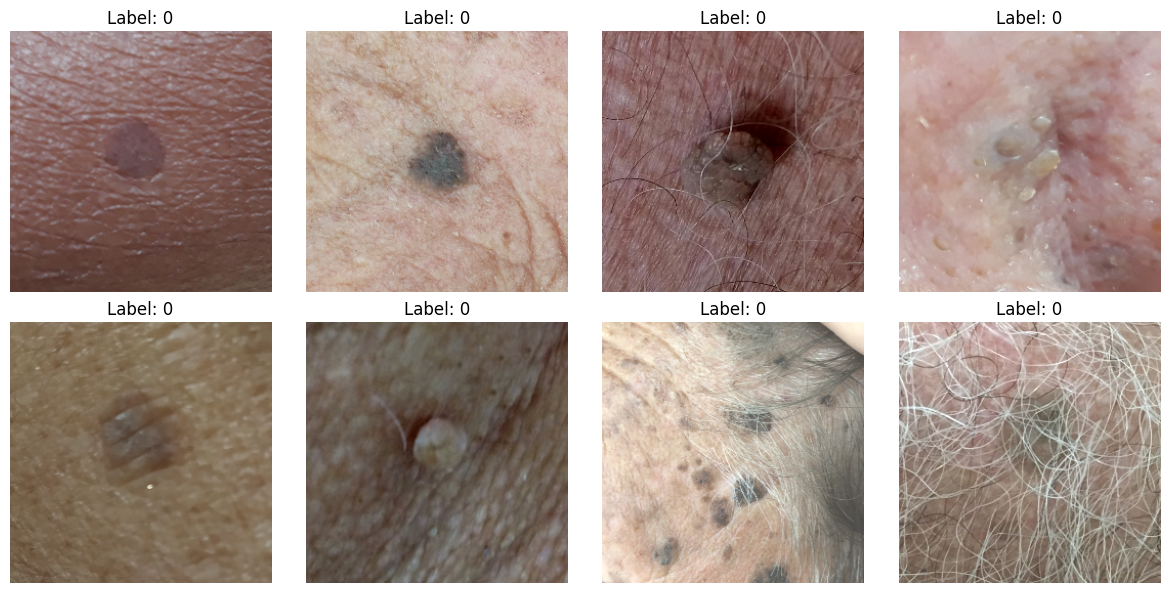

In [20]:
# Call the function with the train_dataset
show_images(train_dataset, class_mode=CLASS_MODE)

After splitting the dataset, which contains 6 classes, into train, val, and test directories, the distribution is as follows: the train directory contains 199 items, the test directory contains 63 items, and the val directory contains 50 items.

# Model for 6 Classes

## ConvMixerModel

### Define the Model

In [21]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        self.deepwise = DepthwiseConv2D(kernel_size=kernel_size, padding='same')
        self.conv1 = Conv2D(filters, kernel_size=1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(self.bn1(X))
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(self.bn2(X))
        print("Shape after block:",X.shape)
        return X

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "kernel_size": self.kernel_size
        }

def ConvMixerModel(img_size, num_classes, num_blocks=2, features=256):
    inp = Input(shape=(*img_size, 3),dtype=tf.float16)
    X = Conv2D(features, 2, 2)(inp)
    X = Activation('gelu')(X)
    X = BatchNormalization()(X)

    for i in range(num_blocks):
        X = ConvMixerBlock(features, 5, name=f'CONVMIXER_{i+1}')(X)

    X = GlobalAveragePooling2D(name='the_last_pooling_layer')(X)
    out = Dense(1 if num_classes == 2 else num_classes, activation='sigmoid' if num_classes == 2 else 'softmax')(X)

    model = Model(inputs=inp, outputs=out)
    return model


### Summary the Model

In [22]:
model1 = ConvMixerModel(IMG_SIZE, NUM_CLASSES)
model1.summary()

Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 256)     3328      
                                                                 
 activation (Activation)     (None, 128, 128, 256)     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 256)    1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 128, 128, 256)    74496     
 )                                                               
                                             

### Compile the Model

In [23]:
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='acc')

### Train the Model

In [24]:
history1 = model1.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, callbacks=[early_stopping])


Epoch 1/50


Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
32/32 [==============================] - ETA: 0s - loss: 1.8878 - acc: 0.1320Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
32/32 [==============================] - 18s 271ms/step - loss: 1.8878 - acc: 0.1320 - val_loss: 1.7792 - val_acc: 0.1159
Epoch 2/50
32/32 [==============================] - 10s 307ms/step - loss: 1.8118 - acc: 0.1920 - val_loss: 1.7656 - val_acc: 0.3237
Epoch 3/50
32/32 [==============================] - 10s 309ms/step - loss: 1.7817 - acc: 0.1800 - val_loss: 1.7576 - val_acc: 0.3237
Epoch 4/50
32/32 [==============================] - 10s 311ms/step - loss: 1.7716 - acc: 0.2280 - val_loss: 1.7538 - val_acc: 0.3237
Epoch 5/50
32/32 [==============================] - 10s 314ms/step - loss: 1.7586 - acc: 0.2930 - val_loss: 1.7473 - val_acc: 0.3237
Epoch 6/50
32/32 [=====

### Evaluate the Model

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 [==============================] - 2s 65ms/step - loss: 1.7284 - acc: 0.3000
Test Loss: 1.7283872365951538
Test Accuracy: 0.30000001192092896


### Plot Training History

In [23]:
def plot_training_history(history):
    """ Plots the training and validation accuracy and loss. """
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Plot for accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
    elif 'acc' in history.history:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

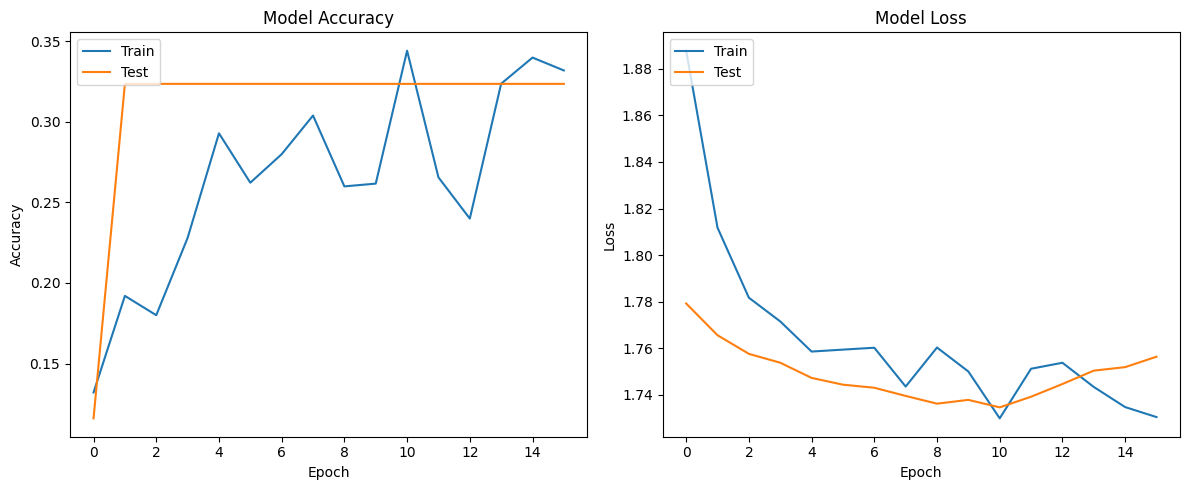

In [27]:
plot_training_history(history1)

## Model Prediction

In [28]:
predictions1 = model1.predict(test_dataset)
model1_y_pred = np.argmax(predictions1, axis=-1)
print(f'Model 1: {classification_report(y_test, model1_y_pred, zero_division=0)}')

Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
29/29 [==============================] - 2s 75ms/step
Model 1:               precision    recall  f1-score   support

           0       0.30      1.00      0.46        69
           1       0.00      0.00      0.00        88
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        22

    accuracy                           0.30       230
   macro avg       0.05      0.17      0.08       230
weighted avg       0.09      0.30      0.14       230



## Save the Model

In [29]:
os.makedirs(destination_path, exist_ok=True)
model1.save(destination_path+'ConvMixerModel6.h5')

## ResNet50

### Define the ResNet50 Model

In [24]:
def resnet50(input_shape, num_classes, base_model_weights='imagenet'):
    """ Create a custom model based on ResNet50 architecture. """
    # Load the ResNet50 model
    base_model = ResNet50(include_top=False, weights=base_model_weights,
                          input_tensor=Input(shape=input_shape),
                          pooling='avg')

    # Add a custom head to the model
    x = base_model.output
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1 if num_classes==2 else num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')(x)

    # Create an instance of the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [25]:
model2 = resnet50(INPUT_SHAPE, num_classes=NUM_CLASSES)


### Summary the Model

In [32]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Compile the Model

In [33]:
model2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics='acc'
)

### Train the Model

In [40]:
history2 = model2.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset,callbacks=[early_stopping])

Epoch 1/50


32/32 [==============================] - 11s 148ms/step - loss: 1.9640 - acc: 0.2440 - val_loss: 2.3569 - val_acc: 0.1159
Epoch 2/50
32/32 [==============================] - 6s 184ms/step - loss: 1.7146 - acc: 0.3203 - val_loss: 2.3680 - val_acc: 0.1159
Epoch 3/50
32/32 [==============================] - 6s 199ms/step - loss: 1.5910 - acc: 0.3975 - val_loss: 2.5266 - val_acc: 0.1159
Epoch 4/50
32/32 [==============================] - 6s 185ms/step - loss: 1.5555 - acc: 0.4240 - val_loss: 2.6420 - val_acc: 0.1159
Epoch 5/50
32/32 [==============================] - 7s 210ms/step - loss: 1.5255 - acc: 0.4400 - val_loss: 2.3129 - val_acc: 0.1159
Epoch 6/50
32/32 [==============================] - 6s 184ms/step - loss: 1.3975 - acc: 0.5391 - val_loss: 3.3865 - val_acc: 0.1159
Epoch 7/50
32/32 [==============================] - 6s 183ms/step - loss: 1.4414 - acc: 0.5246 - val_loss: 2.5273 - val_acc: 0.1159
Epoch 8/50
32/32 [==============================] - 5s 156ms/step - loss: 1.3422 - acc

### Evaluate the Model

In [41]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 7/29 [======>.......................] - ETA: 1s - loss: 2.1697 - acc: 0.1964

29/29 [==============================] - 1s 34ms/step - loss: 2.2590 - acc: 0.1348
Test Loss: 2.259021520614624
Test Accuracy: 0.134782612323761


### Plot Training History

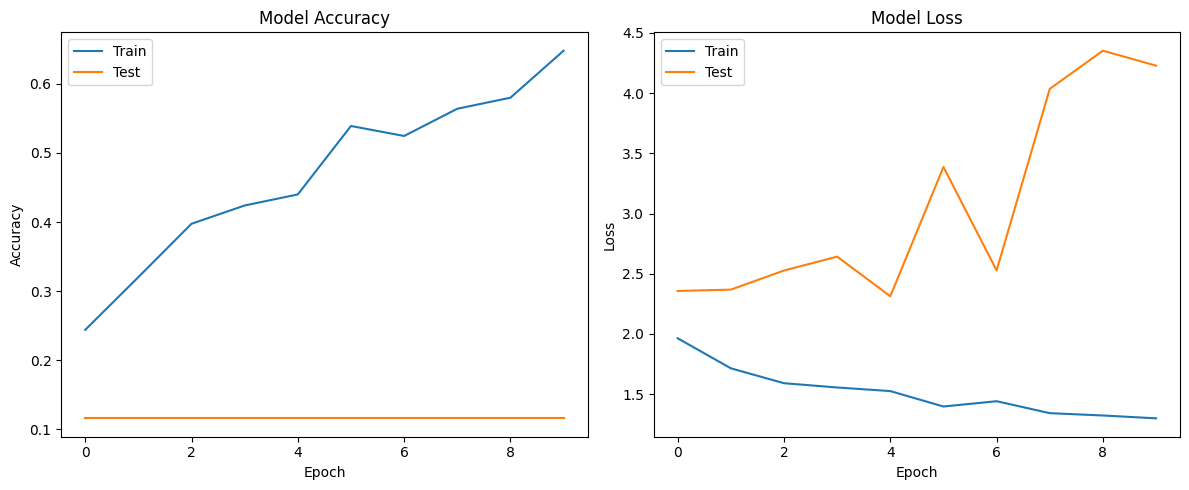

In [42]:
plot_training_history(history2)

## Model Prediction

In [43]:
predictions2 = model2.predict(test_dataset)
model2_y_pred = np.argmax(predictions2, axis=-1)
print(f"Model 2: {classification_report(y_test, model2_y_pred, zero_division=0)}")

15/29 [==============>...............] - ETA: 0s

29/29 [==============================] - 1s 39ms/step
Model 2:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.00      0.00      0.00        88
           2       0.00      0.00      0.00         2
           3       0.13      1.00      0.24        31
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        22

    accuracy                           0.13       230
   macro avg       0.02      0.17      0.04       230
weighted avg       0.02      0.13      0.03       230



## Save the Model

In [44]:
model2.save(destination_path+'ResNet50Model6.h5')

## VGG

### Define the VGG Model

In [26]:
def vgg16(input_shape, num_classes):
    """ Create a custom model based on VGG16 architecture. """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1 if num_classes==2 else num_classes))
    model.add(Activation('softmax' if num_classes > 2 else 'sigmoid'))

    return model

In [27]:
model3 = vgg16(INPUT_SHAPE, NUM_CLASSES)

### Summary the Model

In [47]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 activation_3 (Activation)   (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 122, 122, 64)      36928     
                                                        

### Compile the Model

In [48]:
model3.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics='acc')

### Train the Model

In [51]:
history3 = model3.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/50


32/32 [==============================] - 6s 91ms/step - loss: 1.8918 - acc: 0.0880 - val_loss: 1.8050 - val_acc: 0.0966
Epoch 2/50
32/32 [==============================] - 4s 119ms/step - loss: 1.7960 - acc: 0.1080 - val_loss: 1.7907 - val_acc: 0.1256
Epoch 3/50
32/32 [==============================] - 4s 122ms/step - loss: 1.7912 - acc: 0.1960 - val_loss: 1.7929 - val_acc: 0.1256
Epoch 4/50
32/32 [==============================] - 3s 106ms/step - loss: 1.7882 - acc: 0.2520 - val_loss: 1.7894 - val_acc: 0.3430
Epoch 5/50
32/32 [==============================] - 3s 105ms/step - loss: 1.7901 - acc: 0.1840 - val_loss: 1.7896 - val_acc: 0.2222
Epoch 6/50
32/32 [==============================] - 3s 107ms/step - loss: 1.7886 - acc: 0.1680 - val_loss: 1.7897 - val_acc: 0.1449
Epoch 7/50
32/32 [==============================] - 3s 110ms/step - loss: 1.7905 - acc: 0.1920 - val_loss: 1.7799 - val_acc: 0.3671
Epoch 8/50
32/32 [==============================] - 3s 106ms/step - loss: 1.7893 - acc: 

### Evaluate the Model

In [52]:
# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 3/29 [==>...........................] - ETA: 1s - loss: 1.6715 - acc: 0.2500

29/29 [==============================] - 1s 26ms/step - loss: 1.6648 - acc: 0.2783
Test Loss: 1.6647804975509644
Test Accuracy: 0.27826085686683655


### Plot Training History

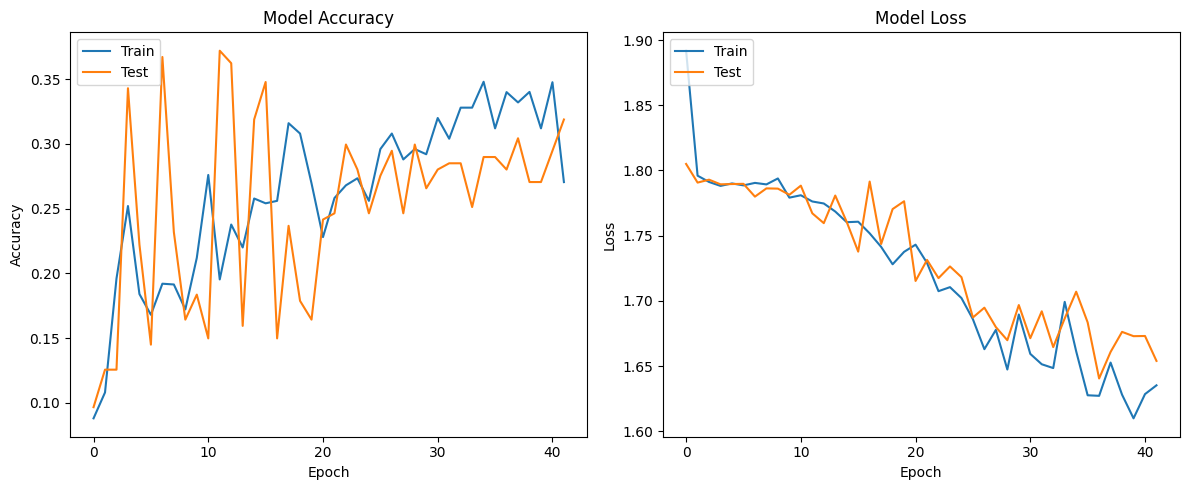

In [53]:
plot_training_history(history3)

## Model Prediction

In [54]:
predictions3 = model3.predict(test_dataset)
model3_y_pred = np.argmax(predictions3, axis=-1)
print(f"Model 3: {classification_report(y_test, model3_y_pred, zero_division=0)}")

 1/29 [>.............................] - ETA: 4s

29/29 [==============================] - 1s 25ms/step
Model 3:               precision    recall  f1-score   support

           0       0.48      0.41      0.44        69
           1       0.50      0.24      0.32        88
           2       0.10      0.50      0.17         2
           3       0.12      0.06      0.09        31
           4       0.08      0.28      0.12        18
           5       0.17      0.32      0.23        22

    accuracy                           0.28       230
   macro avg       0.24      0.30      0.23       230
weighted avg       0.38      0.28      0.30       230



## Save the Model

In [55]:
model3.save(destination_path+'VGG16Model6.h5')

## Big Transfer

### Define the BiT Model

In [28]:
# load the model
module = hub.load(bit_model_url)

In [29]:
class MyBiTModel(keras.Model):
    """ Create a custom model based on the BiT model. """
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        # self.head = keras.layers.Dense(num_classes if num_classes != 2 else 1, kernel_initializer="zeros")
        self.conv1 = keras.layers.Conv2D(32, (3, 3), input_shape=INPUT_SHAPE)
        self.conv2 = keras.layers.Conv2D(32, (3, 3))
        self.activation1 = keras.layers.Activation('relu')
        self.max_pool = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(128)
        self.activation2 = keras.layers.Activation('relu')
        self.dropout = keras.layers.Dropout(0.5)
        self.dense2 = keras.layers.Dense(1 if num_classes == 2 else num_classes)
        self.activation3 = keras.layers.Activation('softmax' if num_classes > 2 else 'sigmoid')
        self.bit_model = module

    def call(self, images):
        x = self.conv1(images)
        x = self.conv2(x)
        x = self.activation1(x)
        x = self.max_pool(x)
        x = self.flatten(x)

        bit_embedding = self.bit_model(images)
        x = keras.layers.concatenate([x, bit_embedding])

        x = self.dense1(x)
        x = self.activation2(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.activation3(x)


In [30]:
model4 = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Summary the Model

In [59]:
dummy_input = tf.random.normal(shape=(1, *INPUT_SHAPE))
_ = model4(dummy_input)
model4.summary()

Model: "my_bi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           multiple                  896       
                                                                 
 conv2d_10 (Conv2D)          multiple                  9248      
                                                                 
 activation_8 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  65290368  
                                                     

### Compile the Model

In [60]:
model4.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='acc')

### Train the Model

In [62]:
history4 = model4.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                        validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/50


32/32 [==============================] - 6s 146ms/step - loss: 1.7918 - acc: 0.1720 - val_loss: 1.7917 - val_acc: 0.0966
Epoch 2/50
32/32 [==============================] - 6s 185ms/step - loss: 1.7911 - acc: 0.1719 - val_loss: 1.7917 - val_acc: 0.0966
Epoch 3/50
32/32 [==============================] - 5s 172ms/step - loss: 1.7907 - acc: 0.1762 - val_loss: 1.7915 - val_acc: 0.1063
Epoch 4/50
32/32 [==============================] - 5s 169ms/step - loss: 1.7890 - acc: 0.1562 - val_loss: 1.7921 - val_acc: 0.0483
Epoch 5/50
32/32 [==============================] - 5s 165ms/step - loss: 1.7821 - acc: 0.2049 - val_loss: 1.7961 - val_acc: 0.0435
Epoch 6/50
32/32 [==============================] - 5s 168ms/step - loss: 1.7943 - acc: 0.1560 - val_loss: 1.8209 - val_acc: 0.0338
Epoch 7/50
32/32 [==============================] - 5s 172ms/step - loss: 1.7948 - acc: 0.1484 - val_loss: 1.7917 - val_acc: 0.0918
Epoch 8/50
32/32 [==============================] - 5s 165ms/step - loss: 1.7907 - acc:

### Evaluate the Model

In [63]:
# Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 [==============================] - 2s 67ms/step - loss: 1.7917 - acc: 0.0870
Test Loss: 1.791715145111084
Test Accuracy: 0.08695652335882187


### Plot Training History

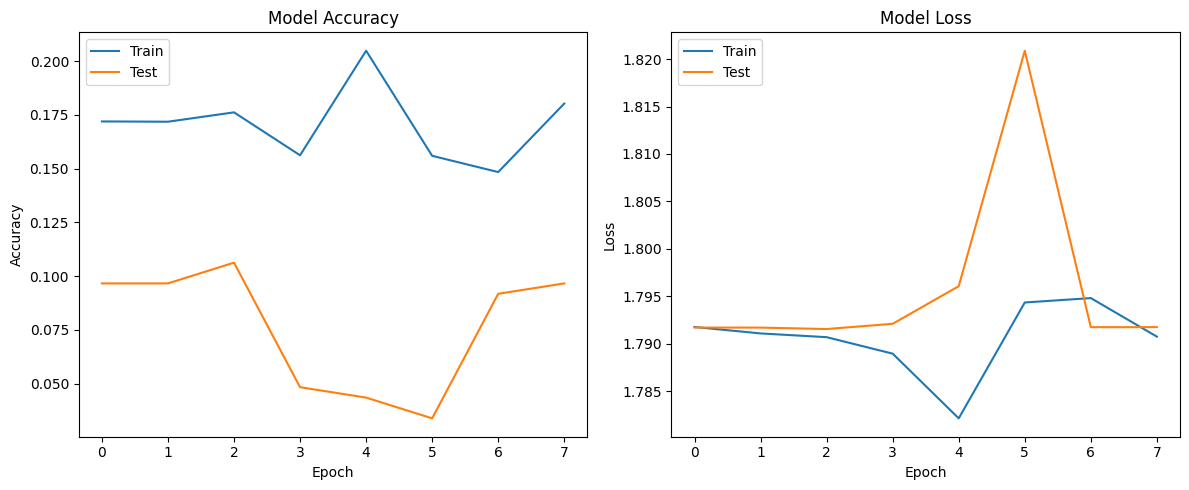

In [64]:
plot_training_history(history4)

## Model Prediction

In [65]:
predictions4 = model4.predict(test_dataset)
model4_y_pred = np.argmax(predictions4, axis=-1)
print(f"Model 4: {classification_report(y_test, model4_y_pred, zero_division=0)}")

29/29 [==============================] - 3s 60ms/step
Model 4:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.00      0.00      0.00        88
           2       0.14      0.50      0.22         2
           3       0.50      0.03      0.06        31
           4       0.08      1.00      0.15        18
           5       0.00      0.00      0.00        22

    accuracy                           0.09       230
   macro avg       0.12      0.26      0.07       230
weighted avg       0.08      0.09      0.02       230



## Save the Model

In [66]:
model4.save(destination_path+'BiTModel6',save_format='tf')
model4.save_weights(os.path.join(destination_path,'\\BiTModel6')+'BiTModel6_weights.h5')

INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\BiTModel6\assets


INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\BiTModel6\assets


## SAM(Segment Anything Model)

### Define the SAM Model

In [31]:
class SAMClassifier:
    def __init__(self, checkpoint_path: str, num_classes: int):
        self.num_classes = num_classes
        self.model = sam_model_registry["vit_h"](checkpoint=checkpoint_path)
        self.predictor = SamPredictor(self.model)
        self.classifier = self._build_classifier()

    def _build_classifier(self):
        inputs = Input(shape=(256, 256, 3))
        x = Conv2D(32, (3, 3))(inputs)
        x = Conv2D(32, (3, 3))(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(self.num_classes if self.num_classes!=2 else 1, activation='softmax' if self.num_classes != 2 else 'sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def preprocess_image(self, image_path):
        image = load_img(image_path, target_size=(256, 256))
        image = img_to_array(image)
        image = preprocess_input(image)
        return image

    def extract_features(self, image):
        self.predictor.set_image(image)
        image_embedding = self.predictor.get_image_embedding()
        return image_embedding

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics='accuracy', **kwargs):
        if self.num_classes == 2:
            loss = 'binary_crossentropy'
            self.classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
        else:
            self.classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)

    def fit(self, train_dataset, val_dataset, epochs: int, callbacks, steps_per_epoch=None, validation_steps=None, class_weight=None):
        history = self.classifier.fit(
            train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            callbacks=callbacks,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            class_weight=class_weight
        )
        return history

    def predict(self, test_dataset):
            predictions = self.classifier.predict(test_dataset)
            return predictions

    def evaluate(self, test_dataset, steps=None):
        loss, accuracy = self.classifier.evaluate(test_dataset, steps=steps)
        return loss, accuracy

    def save(self, filepath):
        self.classifier.save(filepath)
        torch.save(self.model.state_dict(), filepath + '_sam.pth')

    @classmethod
    def load(cls, filepath, num_classes):
        classifier = tf.keras.models.load_model(filepath)
        sam = sam_model_registry["vit_h"](checkpoint=filepath + '_sam.pth')
        sam.load_state_dict(torch.load(filepath + '_sam.pth'))
        instance = cls.__new__(cls)
        instance.num_classes = num_classes
        instance.model = sam
        instance.predictor = SamPredictor(sam)
        instance.classifier = classifier
        return instance

In [32]:
model5 = SAMClassifier(checkpoint_path, NUM_CLASSES)

### Summary the Model

In [60]:
model5.classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 252, 252, 32)      9248      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               16896     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

### Compile the Model

In [69]:
model5.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='acc')

### Train the Model

In [70]:
history5 = model5.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      val_dataset=val_dataset, callbacks=[early_stopping])

Epoch 1/50


32/32 [==============================] - 5s 59ms/step - loss: 1.8045 - acc: 0.1600 - val_loss: 1.7794 - val_acc: 0.3092
Epoch 2/50
32/32 [==============================] - 3s 100ms/step - loss: 1.7987 - acc: 0.1640 - val_loss: 1.7791 - val_acc: 0.3092
Epoch 3/50
32/32 [==============================] - 3s 111ms/step - loss: 1.7999 - acc: 0.1480 - val_loss: 1.7791 - val_acc: 0.3092
Epoch 4/50
32/32 [==============================] - 3s 101ms/step - loss: 1.7905 - acc: 0.1840 - val_loss: 1.7796 - val_acc: 0.3092
Epoch 5/50
32/32 [==============================] - 3s 91ms/step - loss: 1.8024 - acc: 0.1800 - val_loss: 1.7796 - val_acc: 0.3092
Epoch 6/50
32/32 [==============================] - 3s 89ms/step - loss: 1.7864 - acc: 0.2000 - val_loss: 1.7800 - val_acc: 0.3092
Epoch 7/50
32/32 [==============================] - 3s 92ms/step - loss: 1.7998 - acc: 0.1880 - val_loss: 1.7795 - val_acc: 0.3092
Epoch 7: early stopping


### Evaluate the Model

In [63]:
# Evaluate the model on the test set
test_loss, test_accuracy = model5.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 1/29 [>.............................] - ETA: 6s - loss: 1.7764 - acc: 0.3750

29/29 [==============================] - 1s 21ms/step - loss: 1.7679 - acc: 0.3826
Test Loss: 1.7679438591003418
Test Accuracy: 0.38260868191719055


### Plot Training History

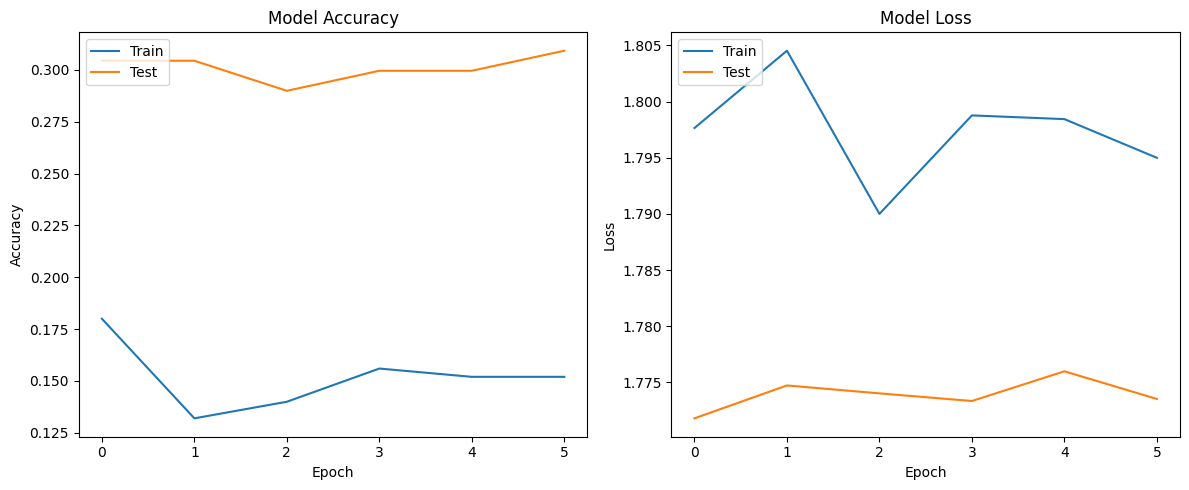

In [64]:
plot_training_history(history5)

## Model Prediction

In [65]:
predictions5 = model5.predict(test_dataset)
model5_y_pred = np.argmax(predictions5, axis=-1)

 2/29 [=>............................] - ETA: 3s

29/29 [==============================] - 1s 20ms/step


In [66]:
predictions5

array([[0.17314264, 0.18147546, 0.17496493, 0.15288204, 0.15648992,
        0.16104503],
       [0.17135172, 0.1832373 , 0.17518738, 0.15302555, 0.1562624 ,
        0.16093564],
       [0.17338389, 0.18022616, 0.17482045, 0.15316984, 0.15679298,
        0.16160662],
       ...,
       [0.17509638, 0.17918192, 0.1755284 , 0.15192482, 0.15668356,
        0.16158494],
       [0.17267036, 0.18061818, 0.17431563, 0.15382218, 0.15722898,
        0.1613447 ],
       [0.1754986 , 0.17905219, 0.17576514, 0.15159011, 0.15644164,
        0.16165234]], dtype=float32)

In [67]:
print(f"Model 5: {classification_report(y_test, model5_y_pred, zero_division=0)}")

Model 5:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.38      1.00      0.56        88
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        22

    accuracy                           0.38       230
   macro avg       0.06      0.17      0.09       230
weighted avg       0.15      0.38      0.21       230



## Save the Model

In [68]:
os.makedirs('G:\\HSUHK\\COM6003\\project\\archive\\model_result\\SAM_Model6', exist_ok=True)
model5.save(os.path.join(destination_path,'SAM_Model6'))

INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\SAM_Model6\assets


INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\SAM_Model6\assets


# Stacking for 6 Classification

In [33]:
def img_preprocessing(img, label):
    """ Image preprocessing function """
    img = tf.io.read_file(img)  # Read the image file
    img = tf.image.decode_png(img, channels=3)  # Decode the PNG image
    img = tf.image.resize(img, IMG_SIZE)  # Resize the image
    img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values to [0, 1] range
    return img, label

loader = tf.data.Dataset.from_tensor_slices((x_train.iloc[:,0], y_train))

train_dataset_limit = (loader.map(img_preprocessing,num_parallel_calls=AUTO)
                            .batch(BATCH_SIZE).prefetch(AUTO))

In [34]:
base_models = [('ConvMixer', model1), ('ResNet50', model2), ('VGG16', model3), ('BiT', model4), ('SAM', model5)]
meta_model = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=1000)
meta_input = np.hstack([model.predict(train_dataset_limit) for _, model in base_models])
meta_val = np.hstack([model.predict(val_dataset) for _, model in base_models])
meta_test = np.hstack([model.predict(test_dataset) for _, model in base_models])
meta_label = y_train

Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
29/29 [==============================] - 1s 29ms/step


In [35]:
df_6_train = pd.concat([x_train.reset_index(drop=True),pd.DataFrame(meta_input)],axis=1,ignore_index=True)
df_6_val = pd.concat([x_val.reset_index(drop=True),pd.DataFrame(meta_val)],axis=1,ignore_index=True)
df_6_test = pd.concat([x_test.reset_index(drop=True),pd.DataFrame(meta_test)],axis=1,ignore_index=True)
df_6_train.to_csv('G:\\HSUHK\\COM6003\\project\\archive\\meta_input_6.csv')
df_6_val.to_csv('G:\\HSUHK\\COM6003\\project\\archive\\meta_val_6.csv')
df_6_test.to_csv('G:\\HSUHK\\COM6003\\project\\archive\\meta_test_6.csv')

In [74]:
# fit the model on the training data
meta_model.fit(meta_input, meta_label)
# make predictions on the test data
meta_input_test = np.hstack([model.predict(test_dataset) for _, model in base_models])
y_pred = meta_model.predict(meta_input_test)
# calculate the classification report
stack_model_6_result = classification_report(y_test, y_pred)
print(f'Stack Model: {stack_model_6_result}')

 1/29 [>.............................] - ETA: 3s

29/29 [==============================] - 1s 27ms/step
Stack Model:               precision    recall  f1-score   support

           0       0.45      0.38      0.41        69
           1       0.47      0.17      0.25        88
           2       0.05      0.50      0.10         2
           3       0.43      0.32      0.37        31
           4       0.10      0.28      0.14        18
           5       0.20      0.41      0.26        22

    accuracy                           0.29       230
   macro avg       0.28      0.34      0.26       230
weighted avg       0.40      0.29      0.31       230



In [75]:
joblib.dump(meta_model, 'G:\\HSUHK\\COM6003\\project\\archive\\model_result\\image_meta_model_6.pkl')

['G:\\HSUHK\\COM6003\\project\\archive\\model_result\\image_meta_model_6.pkl']

# Data Processing for 2 Classes

In [17]:
x_train, x_val, x_test, y_train, y_val, y_test, class_weights, train_path, val_path, test_path = data_preprocessing(data_path, file_name2)

Directories already exist.


In [18]:
train_dataset, val_dataset, test_dataset = create_datagen(x_train, y_train, x_val, y_val, x_test, y_test, img_size=IMG_SIZE, batch_size=BATCH_SIZE)

In [19]:
NUM_CLASSES = y_train.nunique()
CLASS_MODE = 'categorical' if NUM_CLASSES > 2 else 'binary'

# Model for 2 Classes

## ConvMixerModel

### Summary the Model

In [ ]:
model6 = ConvMixerModel(IMG_SIZE, NUM_CLASSES)
model6.summary()

### Compile the Model

In [91]:
model6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='acc')

### Train the Model

In [92]:
history6 = model6.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, callbacks=[early_stopping])


Epoch 1/50


Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
75/75 [==============================] - ETA: 0s - loss: 0.7088 - acc: 0.4950Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
75/75 [==============================] - 22s 233ms/step - loss: 0.7088 - acc: 0.4950 - val_loss: 0.7101 - val_acc: 0.4396
Epoch 2/50
75/75 [==============================] - 20s 233ms/step - loss: 0.6986 - acc: 0.4800 - val_loss: 0.7311 - val_acc: 0.4396
Epoch 3/50
75/75 [==============================] - 20s 233ms/step - loss: 0.6969 - acc: 0.5183 - val_loss: 0.7368 - val_acc: 0.4396
Epoch 4/50
75/75 [==============================] - 20s 233ms/step - loss: 0.6914 - acc: 0.5233 - val_loss: 0.7354 - val_acc: 0.4396
Epoch 5/50
75/75 [==============================] - 20s 233ms/step - loss: 0.6941 - acc: 0.5133 - val_loss: 0.7308 - val_acc: 0.4396
Epoch 6/50
75/75 [=====

### Evaluate the Model

In [93]:
# Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 [==============================] - 2s 61ms/step - loss: 0.7042 - acc: 0.4696
Test Loss: 0.7042399644851685
Test Accuracy: 0.469565212726593


### Plot Training History

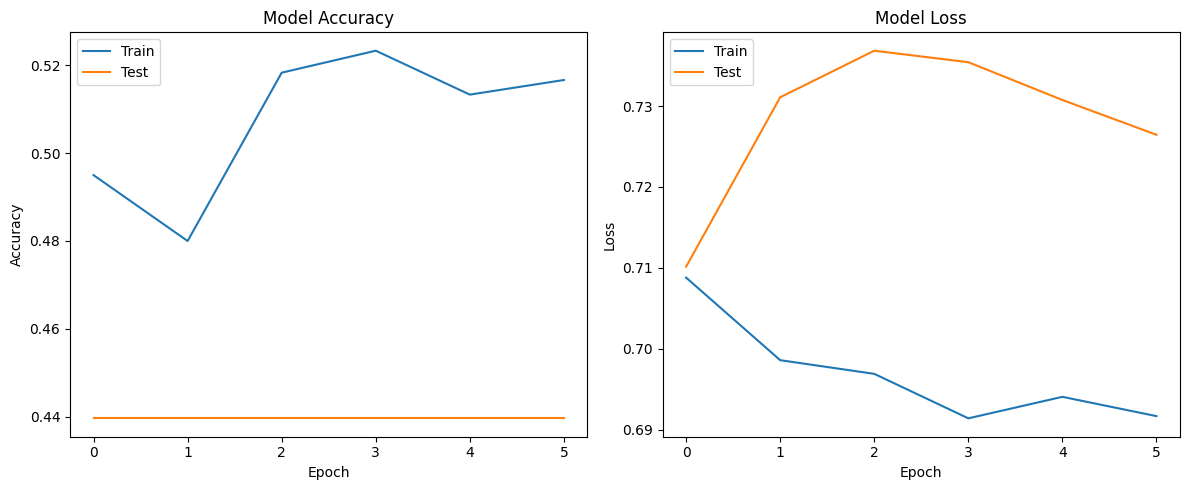

In [94]:
plot_training_history(history6)

## Model Predition

In [95]:
predictions6 = model6.predict(test_dataset)
model6_y_pred = np.where(predictions6 > 0.5, 1, 0)
print(f'Model 6: {classification_report(y_test, model6_y_pred, zero_division=0)}')

Shape after block: (None, 128, 128, 256)
Shape after block: (None, 128, 128, 256)
29/29 [==============================] - 2s 76ms/step
Model 6:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.47      1.00      0.64       108

    accuracy                           0.47       230
   macro avg       0.23      0.50      0.32       230
weighted avg       0.22      0.47      0.30       230



## Save the Model

In [96]:
model6.save(destination_path+'ConvMixerModel2.h5')

## ResNet50

### Define the ResNet50 Model

In [40]:
model7 = resnet50(INPUT_SHAPE, num_classes=NUM_CLASSES)

### Summary the Model

In [63]:
model7.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Compile the Model

In [99]:
model7.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics='acc'
)

### Train the Model

In [100]:
history7 = model7.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/50


75/75 [==============================] - 13s 94ms/step - loss: 0.7486 - acc: 0.4650 - val_loss: 0.7185 - val_acc: 0.4348
Epoch 2/50
75/75 [==============================] - 9s 85ms/step - loss: 0.6603 - acc: 0.5833 - val_loss: 0.8054 - val_acc: 0.4396
Epoch 3/50
75/75 [==============================] - 9s 86ms/step - loss: 0.6040 - acc: 0.7183 - val_loss: 1.1666 - val_acc: 0.4396
Epoch 4/50
75/75 [==============================] - 9s 85ms/step - loss: 0.5635 - acc: 0.7300 - val_loss: 1.2348 - val_acc: 0.4396
Epoch 5/50
75/75 [==============================] - 9s 86ms/step - loss: 0.5397 - acc: 0.7733 - val_loss: 1.2187 - val_acc: 0.4396
Epoch 6/50
75/75 [==============================] - 9s 87ms/step - loss: 0.5124 - acc: 0.8217 - val_loss: 1.8966 - val_acc: 0.4396
Epoch 6: early stopping


### Evaluate the Model

In [101]:
# Evaluate the model on the test set
test_loss, test_accuracy = model7.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 [==============================] - 1s 29ms/step - loss: 0.7091 - acc: 0.4696
Test Loss: 0.7090996503829956
Test Accuracy: 0.469565212726593


### Plot Training History

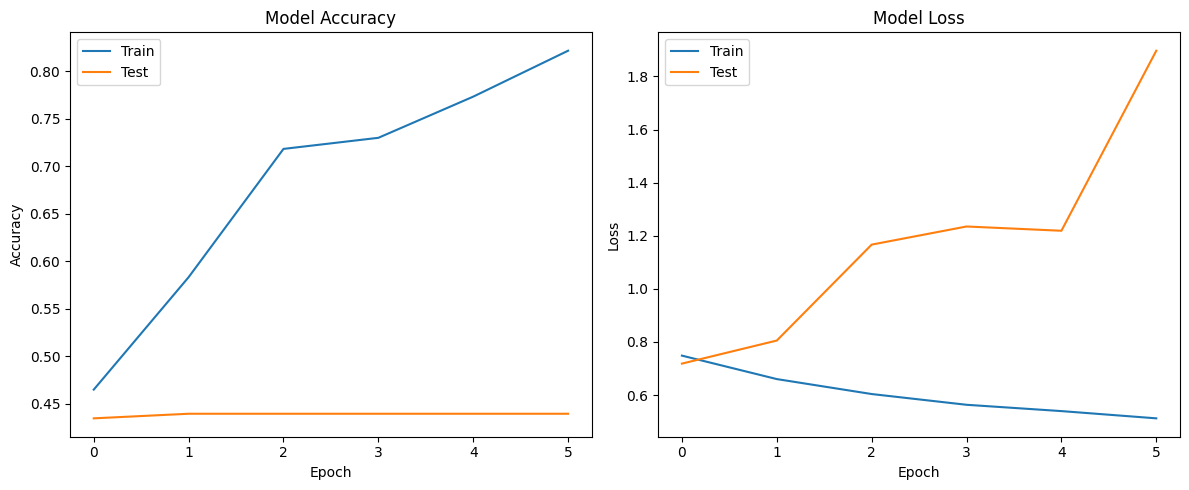

In [102]:
plot_training_history(history7)

## Model Prediction

In [103]:
predictions7 = model7.predict(test_dataset)
model7_y_pred = np.where(predictions7 > 0.5, 1, 0)
print(f"Model 7: {classification_report(y_test, model7_y_pred, zero_division=0)}")

29/29 [==============================] - 1s 27ms/step
Model 7:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.47      1.00      0.64       108

    accuracy                           0.47       230
   macro avg       0.23      0.50      0.32       230
weighted avg       0.22      0.47      0.30       230



## Save the Model

In [ ]:
model7.save(destination_path+'ResNet50Model2.h5')

## VGG

In [41]:
model8 = vgg16(INPUT_SHAPE, NUM_CLASSES)

### Summary the Model

In [65]:
model8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 252, 252, 32)      9248      
                                                                 
 activation_17 (Activation)  (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 124, 124, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 122, 122, 64)      36928     
                                                      

### Compile the Model

In [108]:
model8.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics='acc')

### Train the Model

In [109]:
history8 = model8.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                      validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/50


75/75 [==============================] - 7s 45ms/step - loss: 0.7107 - acc: 0.4717 - val_loss: 0.6918 - val_acc: 0.5604
Epoch 2/50
75/75 [==============================] - 6s 42ms/step - loss: 0.6928 - acc: 0.5283 - val_loss: 0.6908 - val_acc: 0.6184
Epoch 3/50
75/75 [==============================] - 6s 42ms/step - loss: 0.6942 - acc: 0.4983 - val_loss: 0.6890 - val_acc: 0.5652
Epoch 4/50
75/75 [==============================] - 6s 41ms/step - loss: 0.6913 - acc: 0.5267 - val_loss: 0.6906 - val_acc: 0.4879
Epoch 5/50
75/75 [==============================] - 6s 43ms/step - loss: 0.6926 - acc: 0.5017 - val_loss: 0.6887 - val_acc: 0.6812
Epoch 6/50
75/75 [==============================] - 6s 43ms/step - loss: 0.6900 - acc: 0.5333 - val_loss: 0.6867 - val_acc: 0.6280
Epoch 7/50
75/75 [==============================] - 6s 43ms/step - loss: 0.6886 - acc: 0.5417 - val_loss: 0.6846 - val_acc: 0.6812
Epoch 8/50
75/75 [==============================] - 6s 43ms/step - loss: 0.6858 - acc: 0.5733 

### Evaluate the Model

In [110]:
# Evaluate the model on the test set
test_loss, test_accuracy = model8.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 1/29 [>.............................] - ETA: 6s - loss: 0.5418 - acc: 0.8750

29/29 [==============================] - 1s 20ms/step - loss: 0.6220 - acc: 0.7174
Test Loss: 0.621976912021637
Test Accuracy: 0.717391312122345


### Plot Training History

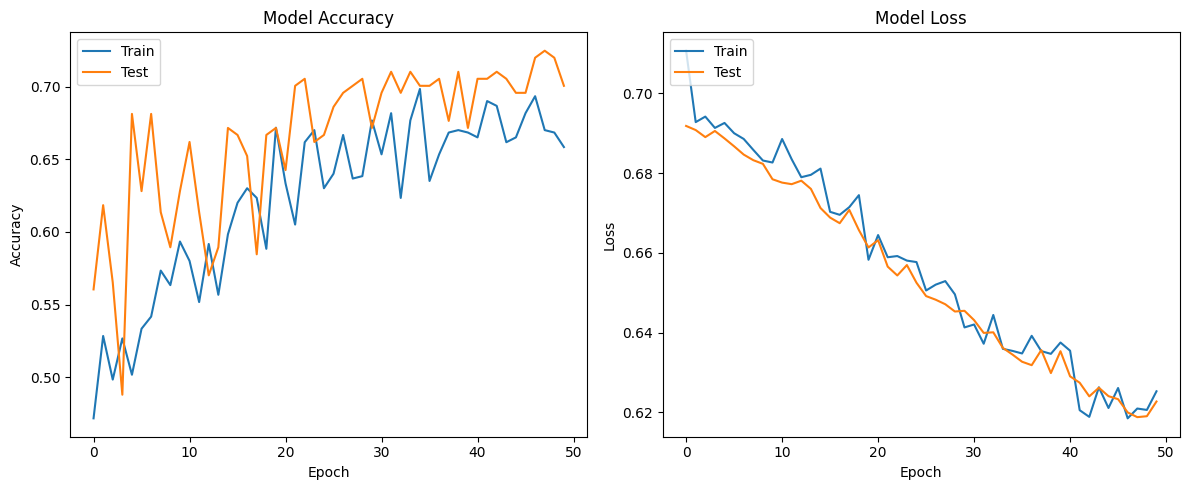

In [111]:
plot_training_history(history8)

## Model Prediction

In [112]:
predictions8 = model8.predict(test_dataset)
model8_y_pred = np.where(predictions8 > 0.5, 1, 0)
print(f"Model 8: {classification_report(y_test, model8_y_pred, zero_division=0)}")

 1/29 [>.............................] - ETA: 3s

29/29 [==============================] - 1s 26ms/step
Model 8:               precision    recall  f1-score   support

           0       0.81      0.61      0.70       122
           1       0.66      0.83      0.73       108

    accuracy                           0.72       230
   macro avg       0.73      0.72      0.72       230
weighted avg       0.74      0.72      0.72       230



## Save the Model

In [ ]:
model8.save(destination_path+'VGG16Model_2.h5')

## Big Transfer

In [42]:
model9 = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Summary the Model

In [67]:
dummy_input = tf.random.normal(shape=(1, *INPUT_SHAPE))
_ = model9(dummy_input)
model9.summary()

Model: "my_bi_t_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          multiple                  896       
                                                                 
 conv2d_25 (Conv2D)          multiple                  9248      
                                                                 
 activation_22 (Activation)  multiple                  0         
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_16 (Dense)            multiple                  65290368  
                                                   

### Compile the Model

In [68]:
model9.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='acc')

### Train the Model

In [69]:
history9 = model9.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                        validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/50


75/75 [==============================] - 14s 98ms/step - loss: 0.8627 - acc: 0.4417 - val_loss: 0.6957 - val_acc: 0.4396
Epoch 2/50
75/75 [==============================] - 10s 84ms/step - loss: 0.6932 - acc: 0.5300 - val_loss: 0.6959 - val_acc: 0.4396
Epoch 3/50
75/75 [==============================] - 9s 84ms/step - loss: 0.6898 - acc: 0.5350 - val_loss: 0.6967 - val_acc: 0.4396
Epoch 4/50
75/75 [==============================] - 10s 87ms/step - loss: 0.6977 - acc: 0.4967 - val_loss: 0.6902 - val_acc: 0.6329
Epoch 5/50
75/75 [==============================] - 10s 87ms/step - loss: 0.6904 - acc: 0.5383 - val_loss: 0.6882 - val_acc: 0.5362
Epoch 6/50
75/75 [==============================] - 10s 86ms/step - loss: 0.6894 - acc: 0.5300 - val_loss: 0.6874 - val_acc: 0.4879
Epoch 7/50
75/75 [==============================] - 9s 85ms/step - loss: 0.6827 - acc: 0.5767 - val_loss: 0.6890 - val_acc: 0.4444
Epoch 8/50
75/75 [==============================] - 10s 87ms/step - loss: 0.6900 - acc: 0

### Evaluate the Model

In [70]:
# Evaluate the model on the test set
test_loss, test_accuracy = model9.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 [==============================] - 2s 48ms/step - loss: 0.6666 - acc: 0.5826
Test Loss: 0.6665539741516113
Test Accuracy: 0.582608699798584


### Plot Training History

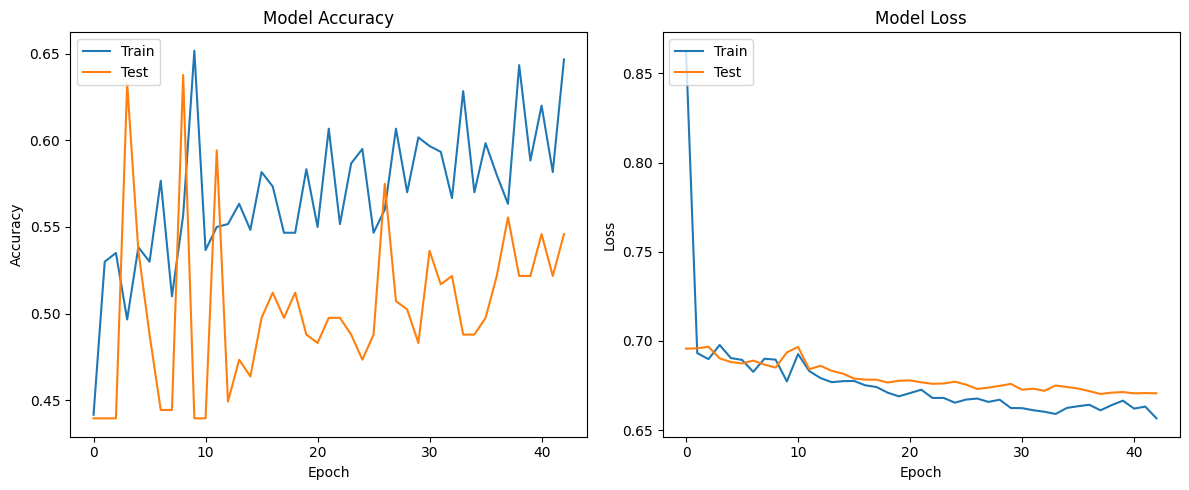

In [71]:
plot_training_history(history9)

## Model Prediction

In [72]:
predictions9 = model9.predict(test_dataset)
model9_y_pred = np.where(predictions9 > 0.5, 1, 0)
print(f"Model 9: {classification_report(y_test, model9_y_pred, zero_division=0)}")

29/29 [==============================] - 2s 54ms/step
Model 9:               precision    recall  f1-score   support

           0       0.93      0.23      0.37       122
           1       0.53      0.98      0.69       108

    accuracy                           0.58       230
   macro avg       0.73      0.61      0.53       230
weighted avg       0.74      0.58      0.52       230



## Save the Model

In [73]:
model9.save(destination_path+'BiTModel2',save_format='tf')
model9.save_weights(os.path.join(destination_path,'\\BiTModel2')+'BiTModel2_weights.h5')

INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\BiTModel2\assets


INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\BiTModel2\assets


## SAM(Segment Anything Model)

### Define the SAM Model

In [43]:
model10 = SAMClassifier(checkpoint_path, NUM_CLASSES)

### Summary the Model

In [ ]:
model10.classifier.summary()

### Compile the Model

In [42]:
model10.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='acc')

### Train the Model

In [43]:
history10 = model10.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(y_train)//BATCH_SIZE,
                        val_dataset=val_dataset, callbacks=[early_stopping])

Epoch 1/50
75/75 [==============================] - 19s 26ms/step - loss: 0.7561 - acc: 0.4850 - val_loss: 0.6972 - val_acc: 0.4396
Epoch 2/50
75/75 [==============================] - 5s 26ms/step - loss: 0.6966 - acc: 0.4867 - val_loss: 0.6989 - val_acc: 0.4396
Epoch 3/50
75/75 [==============================] - 5s 25ms/step - loss: 0.6971 - acc: 0.4850 - val_loss: 0.6947 - val_acc: 0.4396
Epoch 4/50
75/75 [==============================] - 5s 26ms/step - loss: 0.6964 - acc: 0.4983 - val_loss: 0.6948 - val_acc: 0.4396
Epoch 5/50
75/75 [==============================] - 5s 27ms/step - loss: 0.6947 - acc: 0.4783 - val_loss: 0.6947 - val_acc: 0.4396
Epoch 6/50
75/75 [==============================] - 5s 25ms/step - loss: 0.6960 - acc: 0.4750 - val_loss: 0.6931 - val_acc: 0.4734
Epoch 7/50
75/75 [==============================] - 5s 25ms/step - loss: 0.6959 - acc: 0.4950 - val_loss: 0.6927 - val_acc: 0.5942
Epoch 8/50
75/75 [==============================] - 5s 25ms/step - loss: 0.6939 - 

### Evaluate the Model

In [44]:
# Evaluate the model on the test set
test_loss, test_accuracy = model10.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 [==============================] - 1s 22ms/step - loss: 0.6928 - acc: 0.5435
Test Loss: 0.6928170323371887
Test Accuracy: 0.54347825050354


### Plot Training History

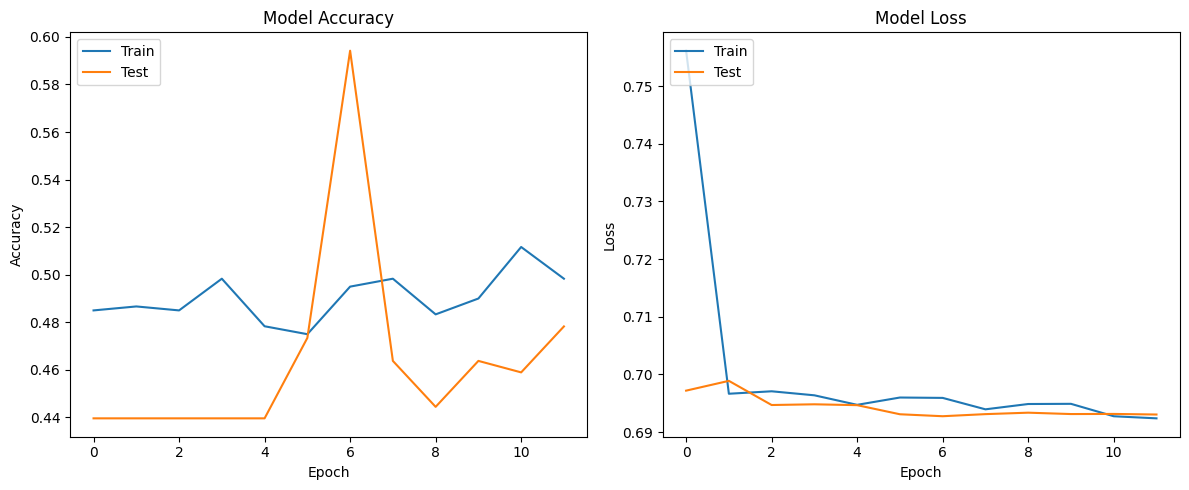

In [45]:
plot_training_history(history10)

## Model Prediction

In [46]:
predictions10 = model10.predict(test_dataset)
model10_y_pred = np.where(predictions10 > 0.5, 1, 0)

29/29 [==============================] - 1s 22ms/step


In [47]:
print(f"Model 10: {classification_report(y_test, model10_y_pred, zero_division=0)}")

Model 10:               precision    recall  f1-score   support

           0       0.54      0.92      0.68       122
           1       0.57      0.12      0.20       108

    accuracy                           0.54       230
   macro avg       0.55      0.52      0.44       230
weighted avg       0.55      0.54      0.45       230



## Save the Model

In [48]:
os.makedirs('G:\\HSUHK\\COM6003\\project\\archive\\model_result\\SAM_Model2', exist_ok=True)
model10.save(os.path.join(destination_path,'SAM_Model2'))

INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\SAM_Model2\assets


INFO:tensorflow:Assets written to: G:\HSUHK\COM6003\project\archive\model_result\SAM_Model2\assets


# Stacking for 2 Classification

In [44]:
loader = tf.data.Dataset.from_tensor_slices((x_train.iloc[:,0], y_train))

train_dataset_limit_2 = (loader.map(img_preprocessing,num_parallel_calls=AUTO)
                            .batch(BATCH_SIZE).prefetch(AUTO))

In [ ]:
base_models_2 = [('ConvMixer_2', model6), ('ResNet50_2', model7), ('VGG16_2', model8), ('BiT_2', model9), ('SAM_2', model10)]
meta_model_2 = LogisticRegression(max_iter=1000)
meta_input_2 = np.hstack([model.predict(train_dataset_limit_2) for _, model in base_models_2])
meta_val_2 = np.hstack([model.predict(val_dataset) for _, model in base_models_2])
meta_test_2 = np.hstack([model.predict(test_dataset) for _, model in base_models_2])
meta_label_2 = y_train

In [56]:
df_2_train = pd.concat([x_train.reset_index(drop=True),pd.DataFrame(meta_input_2)],axis=1,ignore_index=True)
df_2_val = pd.concat([x_val.reset_index(drop=True),pd.DataFrame(meta_val_2)],axis=1,ignore_index=True)
df_2_test = pd.concat([x_test.reset_index(drop=True),pd.DataFrame(meta_test_2)],axis=1,ignore_index=True)
df_2_train.to_csv('G:\\HSUHK\\COM6003\\project\\archive\\meta_input_2.csv')
df_2_val.to_csv('G:\\HSUHK\\COM6003\\project\\archive\\meta_val_2.csv')
df_2_test.to_csv('G:\\HSUHK\\COM6003\\project\\archive\\meta_test_2.csv')

In [57]:
# fit the model on the training data
meta_model_2.fit(meta_input_2, meta_label_2)
# make predictions on the test data
y_pred_2 = meta_model_2.predict(meta_test_2)
# calculate the classification report
stack_model_2_result = classification_report(y_test, y_pred_2)
print(f'Stack Model: {stack_model_2_result}')

Stack Model:               precision    recall  f1-score   support

           0       0.55      0.58      0.56       122
           1       0.49      0.45      0.47       108

    accuracy                           0.52       230
   macro avg       0.52      0.52      0.52       230
weighted avg       0.52      0.52      0.52       230



In [54]:
joblib.dump(meta_model_2, 'G:\\HSUHK\\COM6003\\project\\archive\\model_result\\image_meta_model_2.pkl')

['G:\\HSUHK\\COM6003\\project\\archive\\model_result\\image_meta_model_2.pkl']